In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.types as typ

# sc = pyspark.SparkContext(appName="chp04")
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
fraud = sc.textFile('/home/sha/data/ccFraud.csv.gz')
header = fraud.first()
print(header)

fraud = fraud.filter(lambda row: row != header).map(lambda row: [int(elem) for elem in row.split(',')])

fields = [*[
    typ.StructField(h[1:-1], typ.IntegerType(), True) for h in header.split(',')
]]
print("fields:\n", fields)
schema = typ.StructType(fields)
print("schema:\n", schema)

"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"
fields:
 [StructField(custID,IntegerType,true), StructField(gender,IntegerType,true), StructField(state,IntegerType,true), StructField(cardholder,IntegerType,true), StructField(balance,IntegerType,true), StructField(numTrans,IntegerType,true), StructField(numIntlTrans,IntegerType,true), StructField(creditLine,IntegerType,true), StructField(fraudRisk,IntegerType,true)]
schema:
 StructType(List(StructField(custID,IntegerType,true),StructField(gender,IntegerType,true),StructField(state,IntegerType,true),StructField(cardholder,IntegerType,true),StructField(balance,IntegerType,true),StructField(numTrans,IntegerType,true),StructField(numIntlTrans,IntegerType,true),StructField(creditLine,IntegerType,true),StructField(fraudRisk,IntegerType,true)))


In [3]:
fraud_df = spark.createDataFrame(fraud, schema)
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



In [4]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



In [5]:
import timeit
start = timeit.default_timer()

numerical = ['balance', 'numTrans', 'numIntlTrans']
desc = fraud_df.describe(numerical)
desc.show()

end = timeit.default_timer()
print(str(end - start))

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+

104.77940214699993


In [6]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



In [7]:
start = timeit.default_timer()

n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)

print('corr:\n', corr)

end = timeit.default_timer()
print(str(end - start))

corr:
 [[1.0, 0.00044523140172659576, 0.00027139913398184604], [None, 1.0, -0.0002805712819816179], [None, None, 1.0]]
626.3268983790003


In [9]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [10]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

Text(0.5, 1.0, "Histogram of 'balance'")

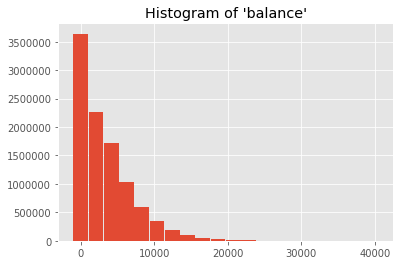

In [11]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data['bins'], data['freq'], width=2000)
plt.title('Histogram of \'balance\'')

In [15]:
plot = figure(plot_width=500, plot_height=300)
plot.vbar(x=data['bins'], width=1000, bottom=0, top=data['freq'], color="#CAB2D6")

show(plot)

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

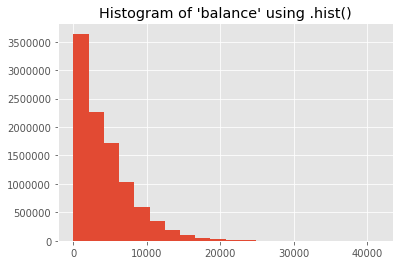

In [16]:
data_driver = {
    'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()
}
plt.hist(data_driver['obs'], bins=20)
plt.title('Histogram of \'balance\' using .hist()')

In [17]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

In [18]:
data_multi = dict([
    (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) for elem in numerical
])

In [21]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"
sctr = figure(tools=TOOLS)
sctr.scatter(data_multi["balance"], data_multi["numTrans"], radius=200, fill_alpha=0.6, line_color=None)
#           fill_color=colors, fill_alpha=0.6,
#           line_color=None)
show(sctr)